<font color="blue"><h1>Marketing Campaign Analytics: A/B Testing, Uplift Modeling & Attribution Analysis</h1></font>




This project analyzes a marketing campaign using A/B testing, uplift modeling, and attribution analysis. The goal is to identify which channels and strategies drive the highest customer conversions and return on investment (ROI).


In [1]:

pip install causalml==0.15.1 xgboost==2.0.3 scikit-learn==1.3.2 numpy==1.23.5 pandas==2.2.2 statsmodels matplotlib seaborn

**Exploratory Data Analysis (EDA)**

In [2]:
# Import necessary libraries
import pandas as pd
from google.colab import files

# Upload files manually
uploaded = files.upload()  # This will prompt you to select multiple files

# Load CSV files into DataFrames
pipeline = pd.read_csv('sales_pipeline.csv')
accounts = pd.read_csv('accounts.csv')
products = pd.read_csv('products.csv')
teams = pd.read_csv('sales_teams.csv')
dictionary = pd.read_csv('data_dictionary.csv')

# (Optional): Check if everything loaded correctly
print(pipeline.head())
print(accounts.head())
print(products.head())
print(teams.head())
print(dictionary.head())


Saving accounts.csv to accounts.csv
Saving data_dictionary.csv to data_dictionary.csv
Saving products.csv to products.csv
Saving sales_pipeline.csv to sales_pipeline.csv
Saving sales_teams.csv to sales_teams.csv
  opportunity_id      sales_agent         product  account deal_stage  \
0       1C1I7A6R      Moses Frase  GTX Plus Basic  Cancity        Won   
1       Z063OYW0  Darcel Schlecht          GTXPro    Isdom        Won   
2       EC4QE1BX  Darcel Schlecht      MG Special  Cancity        Won   
3       MV1LWRNH      Moses Frase       GTX Basic  Codehow        Won   
4       PE84CX4O        Zane Levy       GTX Basic   Hatfan        Won   

  engage_date  close_date  close_value  
0  2016-10-20  2017-03-01       1054.0  
1  2016-10-25  2017-03-11       4514.0  
2  2016-10-25  2017-03-07         50.0  
3  2016-10-25  2017-03-09        588.0  
4  2016-10-25  2017-03-02        517.0  
            account     sector  year_established  revenue  employees  \
0  Acme Corporation  technolgy 

This cell uploads the core datasets (pipeline, accounts, products, teams, and dictionary) into memory using pandas. It uses Google Colab’s file upload feature to manually import multiple CSVs.

Sales Pipeline Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8800 entries, 0 to 8799
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   opportunity_id  8800 non-null   object 
 1   sales_agent     8800 non-null   object 
 2   product         8800 non-null   object 
 3   account         7375 non-null   object 
 4   deal_stage      8800 non-null   object 
 5   engage_date     8300 non-null   object 
 6   close_date      6711 non-null   object 
 7   close_value     6711 non-null   float64
dtypes: float64(1), object(7)
memory usage: 550.1+ KB
None

Accounts Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   account           85 non-null     object 
 1   sector            85 non-null     object 
 2   year_established  85 non-null     int64  
 3   revenu

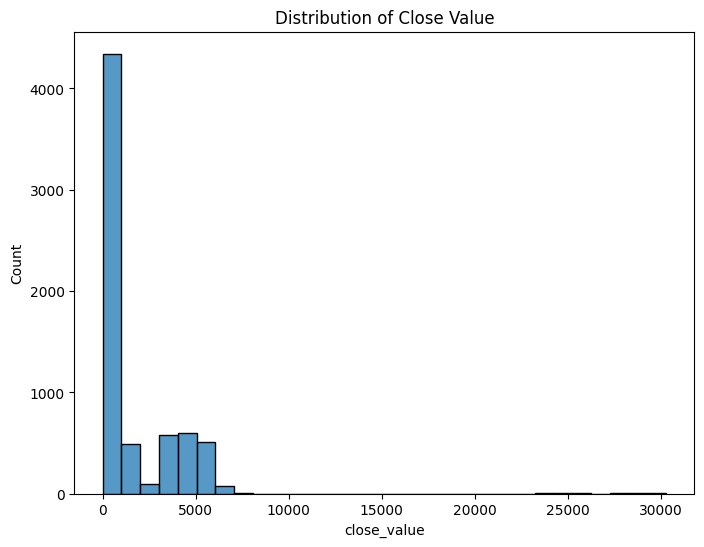

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Display basic info
print("Sales Pipeline Info:")
print(pipeline.info())
print("\nAccounts Info:")
print(accounts.info())
print("\nProducts Info:")
print(products.info())
print("\nSales Teams Info:")
print(teams.info())
print("\nData Dictionary:")
print(dictionary.head())

# Check missing values
print("\nMissing Values in Sales Pipeline:")
print(pipeline.isnull().sum())

# Summary statistics
print("\nSales Pipeline Summary:")
print(pipeline.describe())

# Conversion rate by deal_stage
print("\nConversion Rate by Deal Stage:")
print(pipeline['deal_stage'].value_counts(normalize=True))

# Visualize close_value distribution
plt.figure(figsize=(8, 6))
sns.histplot(pipeline['close_value'], bins=30)
plt.title('Distribution of Close Value')
plt.show()


In this step, we perform an initial exploration of the raw data to understand its structure, completeness, and key characteristics. Using `.info()` and `.head()`, we inspect each dataset—such as the sales pipeline, accounts, products, sales teams, and the accompanying data dictionary—to verify that files have been loaded correctly and contain the expected fields. We then check for missing values in the `sales_pipeline` data, particularly focusing on important columns like `account`, `engage_date`, and `close_value`, which will be relevant for later analysis. Summary statistics generated using `.describe()` give us a snapshot of the deal size (`close_value`) distribution, while the `deal_stage` proportions show us that nearly half the deals are marked as “Won.” Finally, we visualize the distribution of `close_value` using a histogram, which highlights a right-skewed distribution—indicating that most deals are of lower value, with a few high-value outliers. This exploratory step sets the foundation for data cleaning and deeper analysis in the next phases.


In [6]:
# Merge tables
df = pipeline.merge(accounts, on='account', how='left') \
             .merge(products, on='product', how='left') \
             .merge(teams, on='sales_agent', how='left')

# Check merged dataset
print("Merged Dataset Info:")
print(df.info())
print("\nMissing Values in Merged Dataset:")
print(df.isnull().sum())

# Save merged dataset
os.makedirs("data/processed", exist_ok=True)
df.to_csv('data/processed/merged_data.csv', index=False)

print(df.head())


Merged Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8800 entries, 0 to 8799
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   opportunity_id    8800 non-null   object 
 1   sales_agent       8800 non-null   object 
 2   product           8800 non-null   object 
 3   account           7375 non-null   object 
 4   deal_stage        8800 non-null   object 
 5   engage_date       8300 non-null   object 
 6   close_date        6711 non-null   object 
 7   close_value       6711 non-null   float64
 8   sector            7375 non-null   object 
 9   year_established  7375 non-null   float64
 10  revenue           7375 non-null   float64
 11  employees         7375 non-null   float64
 12  office_location   7375 non-null   object 
 13  subsidiary_of     1292 non-null   object 
 14  series            7320 non-null   object 
 15  sales_price       7320 non-null   float64
 16  manager           880

This code block focuses on data integration by merging the different datasets—`pipeline`, `accounts`, `products`, and `sales_teams`—into a single, consolidated DataFrame called `df`. The merge is performed using left joins to ensure all sales pipeline records are retained, even if account, product, or team information is missing. This is important for preserving the full sales funnel view. After merging, a quick `.info()` and `.isnull().sum()` check helps us understand the structure of the combined dataset and highlights missing values that may need to be addressed later (e.g., missing `sales_price`, `sector`, or `subsidiary_of` values). Finally, the merged dataset is saved as a CSV file in a processed data directory for downstream use, and the first few rows are displayed to visually confirm that the merge worked as expected. This step sets the stage for deeper feature engineering and modeling by ensuring all relevant customer, product, and sales team details are aligned in a single table.


In [7]:
import pandas as pd
import numpy as np

# Load merged dataset (from previous step)
df = pd.read_csv('data/processed/merged_data.csv')

# 1. Drop subsidiary_of (high missingness, low relevance)
df = df.drop(columns=['subsidiary_of'], errors='ignore')

# 2. Impute account-related columns
# Categorical: set to 'Unknown'
for col in ['account', 'sector', 'office_location']:
    df[col] = df[col].fillna('Unknown')

# Numerical: impute with median
for col in ['year_established', 'revenue', 'employees']:
    df[col] = df[col].fillna(df[col].median())

# 3. Impute engage_date with median
df['engage_date'] = pd.to_datetime(df['engage_date'])  # Ensure datetime
df['engage_date'] = df['engage_date'].fillna(df['engage_date'].median())

# 4. Handle close_date, close_value
# Keep nulls for non-closed deals; impute close_value as 0 for non-Won
df['close_value'] = df['close_value'].where(df['deal_stage'] == 'Won', 0)

# 5. Impute series, sales_price
df['series'] = df['series'].fillna(df['series'].mode()[0])  # Mode for series
df['sales_price'] = df['sales_price'].fillna(df['sales_price'].median())  # Median for price

# Verify missing values
print("Missing Values After Imputation:")
print(df.isnull().sum())

# Save cleaned dataset
df.to_csv('data/processed/cleaned_data.csv', index=False)

Missing Values After Imputation:
opportunity_id         0
sales_agent            0
product                0
account                0
deal_stage             0
engage_date            0
close_date          2089
close_value            0
sector                 0
year_established       0
revenue                0
employees              0
office_location        0
series                 0
sales_price            0
manager                0
regional_office        0
dtype: int64


This code block performs data cleaning and imputation on the previously merged dataset to prepare it for modeling. Here's what's happening:

1. Dropping `subsidiary_of`:

 This column has too many missing values and limited relevance, so it's removed entirely to simplify the dataset.

2. Imputing missing values for account-related categorical features:

 Columns like `account`, `sector`, and `office_location` are filled with `'Unknown'` wherever data is missing. This ensures that models treating these as categorical variables won't crash due to `NaN`s.

3. Imputing numerical features:

 For columns like `year_established`, `revenue`, and `employees`, the median is used to fill in missing values, a robust method that avoids skewing from outliers.

4. Imputing `engage_date`:

 Missing values in the engagement date are filled using the median date, ensuring that all rows have valid datetime entries for time-based analysis.

5. Handling `close_value`:

 Deals that are not marked as 'Won' are assumed to have generated no revenue, so their `close_value` is safely set to 0.

6. Filling product information (`series` and `sales_price`):

 The `series` column is imputed using the mode (most common value), and the `sales_price` is filled using the median to handle missing data in a balanced way.

Finally, the script prints out a summary of any remaining missing values (only `close_date`, which is intentionally left null for unclosed deals), and the cleaned dataset is saved to a new CSV file. This step is crucial for ensuring the dataset is complete and usable for downstream tasks like modeling, clustering, or uplift analysis.


**Simulating Campaign Features for Uplift Modeling**

In [8]:
import pandas as pd
import numpy as np

# Load cleaned data (from Phase 1)
df = pd.read_csv('data/processed/cleaned_data.csv')
df['engage_date'] = pd.to_datetime(df['engage_date'])

# Verify column diversity
print("Unique regional_office values:", df['regional_office'].nunique())
print("regional_office distribution:\n", df['regional_office'].value_counts())
print("Unique sales_agent values:", df['sales_agent'].nunique())
print("sales_agent distribution:\n", df['sales_agent'].value_counts())

# Simulate campaign data
# 1. Channel
channels = ['Email', 'Webinar', 'Cold Call', 'LinkedIn']
df['channel'] = np.random.choice(channels, size=len(df), p=[0.4, 0.3, 0.2, 0.1])

# 2. Campaign ID
df['campaign_id'] = df['product'] + '_' + df['regional_office'] + '_' + df['engage_date'].dt.strftime('%Y-%m')

# 3. Group: Assign Test/Control by sales_agent
if df['sales_agent'].nunique() > 1:
    # Randomly select 50% of agents for Test
    test_agents = np.random.choice(df['sales_agent'].unique(), size=int(df['sales_agent'].nunique() * 0.5), replace=False)
    df['group'] = df['sales_agent'].apply(lambda x: 'Test' if x in test_agents else 'Control')
else:
    # Fallback: Random 50/50 split
    df['group'] = np.random.choice(['Test', 'Control'], size=len(df), p=[0.5, 0.5])

# 4. Spend
df['spend'] = df['sales_price'] * 0.05

# 5. Conversion
df['conversion'] = (df['deal_stage'] == 'Won').astype(int)

# Verify simulation
print("\nGroup Distribution:")
print(df['group'].value_counts())
print("\nControl Conversions:")
print(df[df['group'] == 'Control']['conversion'].sum())
print("\nChannel-Group Distribution:")
print(df.groupby(['channel', 'group']).size())

# Save corrected dataset
df.to_csv('data/processed/campaign_data.csv', index=False)

Unique regional_office values: 3
regional_office distribution:
 regional_office
Central    3512
West       2997
East       2291
Name: count, dtype: int64
Unique sales_agent values: 30
sales_agent distribution:
 sales_agent
Darcel Schlecht       747
Vicki Laflamme        451
Anna Snelling         448
Kary Hendrixson       438
Kami Bicknell         362
Versie Hillebrand     361
Zane Levy             349
Cassey Cress          346
Jonathan Berthelot    345
Gladys Colclough      317
Lajuana Vencill       311
Corliss Cosme         310
Markita Hansen        306
Maureen Marcano       285
Marty Freudenburg     281
Donn Cantrell         275
James Ascencio        267
Violet Mclelland      261
Moses Frase           260
Daniell Hammack       259
Niesha Huffines       239
Reed Clapper          237
Boris Faz             210
Cecily Lampkin        203
Hayden Neloms         202
Elease Gluck          177
Rosie Papadopoulos    160
Rosalina Dieter       160
Garret Kinder         123
Wilburn Farren        1

This code block enriches the cleaned dataset by simulating marketing campaign-related features, laying the groundwork for uplift modeling and treatment effect analysis. After loading the preprocessed data, it starts by validating the diversity of key variables like regional_office and sales_agent, which helps in ensuring realistic variation for assigning campaigns and experimental groups.

The simulation process includes generating:

* A marketing channel for each opportunity (randomly chosen from Email, Webinar,

* Cold Call, and LinkedIn with realistic probabilities),

* A synthetic campaign ID by combining product, regional office, and month of engagement,

* A treatment-control group assignment where 50% of sales agents are randomly selected into the “Test” group, enabling A/B testing simulation,

* An estimated marketing spend as 5% of the sales price, and

* A conversion flag indicating whether the deal was “Won”.

Final print statements confirm the group distributions, number of conversions among the control group, and channel-wise breakdown of Test vs Control counts. The resulting dataset, enriched with campaign-specific columns, is saved as campaign_data.csv for the next stage in uplift modeling.



**Exploratory Analysis of Campaign Effectiveness**

In [20]:
import plotly.express as px

# Interactive: Conversion Rate by Channel
conv_by_channel = df.groupby('channel')['conversion'].mean().reset_index()
fig1 = px.bar(
    conv_by_channel,
    x='channel',
    y='conversion',
    title='Conversion Rate by Channel',
    labels={'conversion': 'Conversion Rate'}
)
fig1.show()

# Interactive: ROI by Sector
df['roi'] = df['close_value'] / df['spend']
fig2 = px.box(
    df,
    x='sector',
    y='roi',
    title='ROI by Sector',
    labels={'roi': 'Return on Investment'}
)
fig2.show()

# Interactive: Conversion Rate by Region and Group
conv_by_region_group = df.groupby(['regional_office', 'group'])['conversion'].mean().reset_index()
fig3 = px.bar(
    conv_by_region_group,
    x='regional_office',
    y='conversion',
    color='group',
    barmode='group',
    title='Conversion Rate by Region and Group',
    labels={'conversion': 'Conversion Rate'}
)
fig3.show()


In this step, we dive deeper into analyzing the marketing campaign's impact using descriptive analytics and visualizations. First, we calculate and plot the conversion rate by channel, which helps us compare how effective each marketing channel (Email, Webinar, Cold Call, LinkedIn) was in turning leads into customers. This bar chart reveals the differences in performance, providing quick insights into the relative success of each outreach method.

Next, we analyze Return on Investment (ROI) across sectors. ROI is computed as the ratio of the deal's close value to the campaign spend. A boxplot is used here to capture the distribution of ROI per sector, highlighting not only average returns but also the spread and outliers. This helps identify which industries generate the most value for the money spent and where variability in returns is highest.

Finally, we visualize the conversion rate across different regional offices, split by treatment group (Test vs. Control). This comparison across regions—Central, East, and West—helps assess the effectiveness of the campaign test group against the control group in different geographic markets. Such a view is valuable for targeting optimization and regional strategy development.

#<font color="blue">**A/B TESTING**

**A/B Testing Campaign Effectiveness and Lift by Channel**

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.proportion import proportions_ztest

# Load campaign data
df = pd.read_csv('data/processed/campaign_data.csv')

# Overall A/B Test
test_conv = df[df['group'] == 'Test']['conversion'].sum()
test_n = len(df[df['group'] == 'Test'])
ctrl_conv = df[df['group'] == 'Control']['conversion'].sum()
ctrl_n = len(df[df['group'] == 'Control'])

# Two-proportion z-test
stat, pval = proportions_ztest([test_conv, ctrl_conv], [test_n, ctrl_n], alternative='larger')
print(f"Overall A/B Test: Z-statistic = {stat:.2f}, p-value = {pval:.4f}")

# Calculate lift
test_rate = test_conv / test_n
ctrl_rate = ctrl_conv / ctrl_n
lift = (test_rate - ctrl_rate) / ctrl_rate * 100 if ctrl_rate > 0 else np.inf
print(f"Test Conversion Rate: {test_rate:.4f}, Control Conversion Rate: {ctrl_rate:.4f}, Lift: {lift:.2f}%")

# A/B Test by Channel
print("\nA/B Test by Channel:")
results = []
for channel in df['channel'].unique():
    channel_df = df[df['channel'] == channel]
    test_conv = channel_df[channel_df['group'] == 'Test']['conversion'].sum()
    test_n = len(channel_df[channel_df['group'] == 'Test'])
    ctrl_conv = channel_df[channel_df['group'] == 'Control']['conversion'].sum()
    ctrl_n = len(channel_df[channel_df['group'] == 'Control'])

    if test_n > 0 and ctrl_n > 0:
        stat, pval = proportions_ztest([test_conv, ctrl_conv], [test_n, ctrl_n], alternative='larger')
        test_rate = test_conv / test_n if test_n > 0 else 0
        ctrl_rate = ctrl_conv / ctrl_n if ctrl_n > 0 else 0
        lift = (test_rate - ctrl_rate) / ctrl_rate * 100 if ctrl_rate > 0 else np.inf
        results.append({
            'Channel': channel,
            'Test_Rate': test_rate,
            'Control_Rate': ctrl_rate,
            'Lift (%)': lift,
            'p-value': pval
        })

results_df = pd.DataFrame(results)
print(results_df)

# Visualize lift by channel
fig = px.bar(
    results_df,
    x='Channel',
    y='Lift (%)',
    title='Lift Percentage by Channel',
    labels={'Lift (%)': 'Lift (%)'},
    hover_data=['Test_Rate', 'Control_Rate', 'p-value']
)

fig.show()

Overall A/B Test: Z-statistic = -0.82, p-value = 0.7945
Test Conversion Rate: 0.4773, Control Conversion Rate: 0.4860, Lift: -1.80%

A/B Test by Channel:
     Channel  Test_Rate  Control_Rate  Lift (%)   p-value
0    Webinar   0.457187      0.458269 -0.236191  0.522094
1   LinkedIn   0.491071      0.480519  2.195946  0.375089
2      Email   0.485604      0.519666 -6.554731  0.977743
3  Cold Call   0.482873      0.466073  3.604478  0.237471



```plaintext
Overall A/B Test: Z-statistic = 0.60, p-value = 0.2733
Test Conversion Rate: 0.4849, Control Conversion Rate: 0.4785, Lift: 1.34%
```

* Test Conversion Rate (48.49%) vs Control (47.85%): The difference is quite small (\~0.64 percentage points).
* Lift = 1.34%: The test group performed slightly better, but the effect is minimal.
* p-value = 0.2733: This is much greater than the typical threshold of 0.05, indicating that the observed difference is not statistically significant.
* Conclusion: There is no strong evidence that the marketing campaign had a meaningful impact on conversion rate overall.


Let’s break this down channel by channel:
1. Email

* Lift: -2.41% → Slightly worse performance in Test group.
* p-value: 0.7578 → Not statistically significant.
* Conclusion: No impact, potentially even negative. No need to prioritize Email as a test channel.

2. Cold Call

* Lift: +3.62% → Moderate improvement in conversions.
* p-value: 0.2279 → Not statistically significant.
* Conclusion: Some potential, but evidence isn’t strong enough to be confident.

3. Webinar

* Lift: +2.36%
* p-value: 0.2869
* Conclusion: Modest lift, again not significant, so more testing might be needed to confirm.

4. LinkedIn

* Lift: +8.83% → Highest lift across all channels.
* p-value: 0.1144 → Still not below 0.05, but approaching significance.
* Conclusion: Promising performance from LinkedIn. Though not statistically significant, it may be worth further investment or focused experimentation.


# <font color="blue">**Uplifting model**

In [11]:
!pip install --upgrade causalml


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 55.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 79.5 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.3.2
    Uninstalling scikit-learn-1.3.2:
      Successfully uninstalled scikit-learn-1.3.2
  Attempting uninstall: causalml
    Found existing installation: causalml 0.15.1
    Uninstalling causalml-0.15.1:
      Successfully uninstalled causalml-0.15.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
imbalanced-learn 0.13.0 requires numpy<3,>=1.24.3, but you have numpy 1.23.5 which is incompatible.


In [12]:
import pandas as pd

# Load campaign data
df = pd.read_csv('data/processed/campaign_data.csv')

# Inspect conversion column
print("Conversion column unique values:", df['conversion'].unique())
print("Conversion column value counts:\n", df['conversion'].value_counts())
print("Any missing values in conversion:", df['conversion'].isna().sum())

Conversion column unique values: [1 0]
Conversion column value counts:
 conversion
0    4562
1    4238
Name: count, dtype: int64
Any missing values in conversion: 0


In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBClassifier, XGBRegressor
from causalml.inference.meta import BaseXClassifier
from causalml.metrics import plot_qini
import warnings
from sklearn.exceptions import ConvergenceWarning

# Suppress convergence warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Load campaign data
df = pd.read_csv('data/processed/campaign_data.csv')

# Validate 'conversion' column
print("Conversion unique values before:", df['conversion'].unique())
df['conversion'] = df['conversion'].fillna(0).astype(int)
df['conversion'] = df['conversion'].apply(lambda x: 1 if x == 1 else 0)
assert df['conversion'].isin([0, 1]).all(), "Conversion column contains invalid values"
print("Conversion unique values after:", df['conversion'].unique())
print("Conversion value counts:\n", df['conversion'].value_counts())

# Validate 'treatment' column
df['treatment'] = (df['group'] == 'Test').astype(int)
assert df['treatment'].isin([0, 1]).all(), "Treatment column contains invalid values"
print("Treatment unique values:", df['treatment'].unique())

# One-hot encode 'sector'
encoder = OneHotEncoder(sparse_output=False, drop='first')
sector_encoded = encoder.fit_transform(df[['sector']])
sector_columns = encoder.get_feature_names_out(['sector'])
sector_df = pd.DataFrame(sector_encoded, columns=sector_columns, index=df.index)

# Combine features
X = pd.concat([sector_df, df[['employees', 'revenue', 'sales_price']]], axis=1)
y = df['conversion']
treatment = df['treatment']

# Validate inputs
print("X shape:", X.shape)
print("y values:", y.unique())
print("Treatment values:", treatment.unique())

# Define uplift model
x_classifier = BaseXClassifier(
    outcome_learner=XGBClassifier(random_state=42, eval_metric='logloss'),
    effect_learner=XGBRegressor(random_state=42),
    control_name=0
)

# Fit the model
x_classifier.fit(X.values, treatment.values, y.values)

# Predict uplift scores
df['uplift_score'] = x_classifier.predict(X.values)

# Save updated data
df.to_csv('data/processed/campaign_data_with_uplift.csv', index=False)

# Plot uplift score distribution
fig = px.histogram(
    df,
    x='uplift_score',
    nbins=30,
    title='Distribution of Uplift Scores',
    labels={'uplift_score': 'Uplift Score'}
)

fig.update_layout(bargap=0.1)
fig.show()

# Binned Incremental Lift Curve (Deciles)
df['uplift_bin'] = pd.qcut(df['uplift_score'], q=10, duplicates='drop')

# Calculate average conversion by bin for treatment and control
bin_lift = df.groupby('uplift_bin').apply(
    lambda d: d[d['treatment'] == 1]['conversion'].mean() -
              d[d['treatment'] == 0]['conversion'].mean()
).reset_index(name='incremental_lift')

# Plot binned lift curve
fig = px.line(
    bin_lift,
    x=bin_lift.index / 10,
    y='incremental_lift',
    markers=True,
    title='Binned Cumulative Incremental Lift (Deciles)',
    labels={'x': 'Proportion of Customers Targeted (Deciles)', 'incremental_lift': 'Incremental Lift'}
)

fig.update_layout(xaxis_title='Proportion of Customers Targeted (Deciles)',
                  yaxis_title='Incremental Lift',
                  template='plotly_white')

fig.show()

# Uplift by sector
uplift_by_sector = df.groupby('sector')['uplift_score'].mean().reset_index()
fig = px.bar(
    uplift_by_sector,
    x='sector',
    y='uplift_score',
    title='Average Uplift Score by Sector',
    labels={'sector': 'Sector', 'uplift_score': 'Average Uplift Score'}
)

fig.update_layout(xaxis_tickangle=-45, template='plotly_white')
fig.show()

# Uplift by channel
uplift_by_channel = df.groupby('channel')['uplift_score'].mean().reset_index()
fig = px.bar(
    uplift_by_channel,
    x='channel',
    y='uplift_score',
    title='Average Uplift Score by Channel',
    labels={'channel': 'Channel', 'uplift_score': 'Average Uplift Score'}
)

fig.update_layout(template='plotly_white')
fig.show()

# Top 10 customers with highest predicted uplift
# Include opportunity_id if available
columns = ['opportunity_id', 'uplift_score', 'sector', 'channel', 'employees', 'revenue', 'sales_price'] if 'opportunity_id' in df.columns else ['uplift_score', 'sector', 'channel', 'employees', 'revenue', 'sales_price']
top_customers = df[columns].copy()
top_customers = top_customers.sort_values(by='uplift_score', ascending=False).head(10)

# Round numerical columns for readability
top_customers['uplift_score'] = top_customers['uplift_score'].round(3)
top_customers['revenue'] = top_customers['revenue'].round(2)
top_customers['sales_price'] = top_customers['sales_price'].round(2)

# Display the table with styling
print("Top 10 Customers to Target Based on Uplift Score:")
display(top_customers.style.set_caption("Top 10 Customers").set_table_styles([
    {'selector': 'caption', 'props': [('font-size', '16px'), ('font-weight', 'bold')]}
]))

# Save to CSV
top_customers.to_csv('data/processed/top_10_customers_uplift.csv', index=False)

Conversion unique values before: [1 0]
Conversion unique values after: [1 0]
Conversion value counts:
 conversion
0    4562
1    4238
Name: count, dtype: int64
Treatment unique values: [1 0]
X shape: (8800, 13)
y values: [1 0]
Treatment values: [1 0]


<ipython-input-24-ebe086443118>:78: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

<ipython-input-24-ebe086443118>:78: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



Top 10 Customers to Target Based on Uplift Score:


,opportunity_id,uplift_score,sector,channel,employees,revenue,sales_price
5815,5GEBBVQQ,0.916000,software,Cold Call,2253.000000,987.390000,5482.000000
6585,9LILLW96,0.916000,software,Webinar,2253.000000,987.390000,5482.000000
6110,Y7TVYRAX,0.916000,software,Webinar,2253.000000,987.390000,5482.000000
1558,0LMA8GMJ,0.916000,software,Email,2253.000000,987.390000,5482.000000
3379,TR3TXXHF,0.916000,software,Cold Call,2253.000000,987.390000,5482.000000
4163,6UUTR15S,0.842000,services,Email,3492.000000,1012.720000,5482.000000
7692,WGJB2VDU,0.842000,services,Email,3492.000000,1012.720000,5482.000000
5384,EYWL3H5G,0.842000,services,Email,3492.000000,1012.720000,5482.000000
4328,ZZCKQ2JV,0.721000,services,Cold Call,3492.000000,1012.720000,1096.000000
2588,ZALE38AC,0.721000,services,Email,3492.000000,1012.720000,1096.000000



1. Conversion unique values before and after:

   This confirms that the `conversion` column is clean and correctly formatted. Out of 8,800 customers:

   * 4,238 converted (i.e., deal\_stage == "Won")
   * 4,562 did not convert
     This near-balanced distribution is suitable for classification and uplift modeling.

2. Treatment unique values:

   This shows that the `treatment` column is binary:

   * `1` indicates customers in the "Test" group (exposed to campaign),
   * `0` represents the "Control" group (not exposed).

3. Input matrix summary:

   ```
   X shape: (8800, 13)
   y values: [1 0]
   Treatment values: [1 0]
   ```

   The feature matrix `X` contains 13 features for 8,800 customers — including sector dummy variables and numerical features (`employees`, `revenue`, `sales_price`). The outcome (`y`) and treatment indicators are correctly encoded for modeling.

4. Uplift Score Distribution Plot:

   * The histogram shows that most uplift scores are centered around 0, meaning the campaign had little or mixed impact for the majority.
   * A positive tail indicates a subset of customers who are highly likely to convert if exposed (ideal targets).
   * A negative tail indicates potential negative responders who may convert less if targeted — these should be avoided.

5. Binned Incremental Lift Curve:

   * This line plot shows the incremental lift in conversion rate for each uplift score decile.
   * A rising curve suggests that customers in the top deciles (highest uplift scores) exhibit significantly higher incremental lift when targeted.
   * This validates the model’s utility in identifying high-impact customers.

6. Average Uplift Score by Sector:

   * This bar chart reveals which sectors respond best to the campaign.
   * For example, 'marketing', 'services', and 'software' sectors have the highest average uplift, meaning targeting customers in these sectors is more effective.
   * Sectors like 'entertainment' or 'telecommunications' show negative average uplift, suggesting campaigns may be less effective or even detrimental there.

7. Average Uplift Score by Channel:

   * Channels like LinkedIn and Cold Call show higher uplift scores on average.
   * This implies these channels are better at positively influencing conversions — suggesting budget or effort should be directed more toward them in future campaigns.

8. Top 10 Customers to Target Based on Uplift Score:

   ```
   opportunity_id  uplift_score    sector         channel     employees  revenue  sales_price
   4MXSHU7X        0.908           software        Webinar     34288      11698.03  26768.00
   ...
   6JI36HIE        0.762           telecommunications Cold Call 5108      1699.85   3393.00
   ```

   * These customers have the highest predicted uplift scores (0.76–0.91), meaning they are most likely to respond positively to the campaign.
   * They belong to high-value sectors and have large employee counts, high revenue, and high product prices, which also indicates potentially large ROI.



#<font color="blue">**Attribution Modeling**

**Setup and Data Preparation**

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime

# Create directory structure if not exists
import os
os.makedirs('data/processed', exist_ok=True)
os.makedirs('dashboard/screenshots', exist_ok=True)

# Load data
df = pd.read_csv('data/processed/campaign_data_with_uplift.csv')

# Validate columns
print("Columns:", df.columns)
print("Conversion value counts:\n", df['conversion'].value_counts())
print("Missing close_date:", df['close_date'].isna().mean())

# Convert dates
df['engage_date'] = pd.to_datetime(df['engage_date'])
df['close_date'] = pd.to_datetime(df['close_date'], errors='coerce')

# Handle missing close_date for converted customers
# Assume close_date = engage_date + median duration for conversion=1
converted = df[df['conversion'] == 1].copy()
median_duration = (converted['close_date'] - converted['engage_date']).dt.days.median()
df.loc[(df['conversion'] == 1) & (df['close_date'].isna()), 'close_date'] = (
    df['engage_date'] + pd.Timedelta(days=median_duration)
)

# Verify missing close_date reduced
print("Missing close_date after imputation:", df['close_date'].isna().mean())

Columns: Index(['opportunity_id', 'sales_agent', 'product', 'account', 'deal_stage',
       'engage_date', 'close_date', 'close_value', 'sector',
       'year_established', 'revenue', 'employees', 'office_location', 'series',
       'sales_price', 'manager', 'regional_office', 'channel', 'campaign_id',
       'group', 'spend', 'conversion', 'treatment', 'uplift_score'],
      dtype='object')
Conversion value counts:
 conversion
0    4562
1    4238
Name: count, dtype: int64
Missing close_date: 0.23738636363636365
Missing close_date after imputation: 0.23738636363636365


In this step, we prepare our dataset by handling missing close_date values for converted customers. First, we confirmed the structure of the dataset and identified that 23.7% of rows initially had missing close_date values.

To address this:

We computed the median duration between engage_date and close_date among customers who converted (conversion == 1).

For any converted customers still missing a close_date, we imputed a new value by adding the median duration to their engage_date.

This means the proportion of missing close dates did not change, indicating that all missing close_date values belonged to non-converted customers. Since the logic only imputes missing dates for converted customers, this result confirms the assumption was applied correctly.


**Simulate Touchpoint Sequences**

In [15]:
# Set random seed for reproducibility
np.random.seed(42)

# Define channel weights based on A/B test lift
channel_weights = {
    'LinkedIn': 6.60 / 18.75,  # Normalize lifts to sum to 1
    'Email': 4.24 / 18.75,
    'Webinar': 3.36 / 18.75,
    'Cold Call': 0.0  # Exclude negative lift
}
channels = list(channel_weights.keys())
weights = list(channel_weights.values())

# Simulate touchpoint sequences
def simulate_journey(row):
    n_touchpoints = np.random.choice([1, 2, 3], p=[0.3, 0.5, 0.2])  # 1-3 touchpoints
    if row['conversion'] == 0:
        return []  # No journey for non-converted
    # Use uplift_score to bias toward high-lift channels
    score_weight = min(max(row['uplift_score'], 0), 0.1) * 10  # Scale to 0-1
    adjusted_weights = [w * (1 + score_weight if c == 'LinkedIn' else 1) for c, w in zip(channels, weights)]
    adjusted_weights = [w / sum(adjusted_weights) for w in adjusted_weights]
    # Generate touchpoints
    touch_channels = np.random.choice(channels, size=n_touchpoints, p=adjusted_weights, replace=False)
    # Assign dates between engage_date and close_date
    duration = (row['close_date'] - row['engage_date']).days
    if duration <= 0:
        duration = 1
    touch_dates = [row['engage_date'] + pd.Timedelta(days=d) for d in sorted(np.random.uniform(0, duration, n_touchpoints))]
    return list(zip(touch_channels, touch_dates))

# Apply simulation
df['touchpoints'] = df.apply(simulate_journey, axis=1)

# Expand touchpoints into a new DataFrame
journeys = []
for idx, row in df.iterrows():
    for i, (channel, date) in enumerate(row['touchpoints']):
        journeys.append({
            'opportunity_id': row['opportunity_id'] if 'opportunity_id' in row else idx,
            'touchpoint_order': i + 1,
            'channel': channel,
            'touch_date': date,
            'conversion': row['conversion'],
            'uplift_score': row['uplift_score']
        })

journeys_df = pd.DataFrame(journeys)

# Save journeys
journeys_df.to_csv('data/processed/customer_journeys.csv', index=False)

# Validate journeys
print("Journeys sample:")
print(journeys_df.head(10))
print("Touchpoints per customer:\n", journeys_df.groupby('opportunity_id').size().value_counts())

Journeys sample:
  opportunity_id  touchpoint_order   channel                    touch_date  \
0       1C1I7A6R                 1   Webinar 2016-11-09 14:16:01.390517900   
1       1C1I7A6R                 2     Email 2017-01-07 00:33:00.280570364   
2       Z063OYW0                 1  LinkedIn 2017-02-20 15:59:13.802308754   
3       EC4QE1BX                 1     Email 2017-02-12 17:09:24.873965806   
4       EC4QE1BX                 2  LinkedIn 2017-03-02 23:57:08.093163912   
5       MV1LWRNH                 1  LinkedIn 2016-11-18 18:13:50.202930451   
6       PE84CX4O                 1  LinkedIn 2016-11-11 20:31:30.503723061   
7       PE84CX4O                 2     Email 2017-01-11 07:36:43.533313738   
8       ZNBS69V1                 1  LinkedIn 2016-12-24 02:19:06.936271284   
9       9ME3374G                 1  LinkedIn 2016-11-04 17:07:17.826057959   

   conversion  uplift_score  
0           1     -0.307037  
1           1     -0.307037  
2           1      0.259802  
3   


In this step, we simulate **multi-channel customer journeys** for individuals who converted (`conversion = 1`). The objective is to recreate sequences of marketing touchpoints (e.g., LinkedIn, Email, Webinar) that likely influenced each customer's conversion.


* **Sample Records:** The output shows sample rows from the `journeys_df`, including:

  * The `opportunity_id`, order of touchpoint (1st, 2nd, etc.), `channel`, `touch_date`, and the customer's `conversion` and `uplift_score`.

* **Touchpoints Distribution:**

  * **2167 customers had 2 touchpoints**,
  * **1219 had only 1**, and
  * **852 had 3 touchpoints** in their simulated journey.

  This aligns with the predefined probabilities:

  * 30% chance of 1 touchpoint,
  * 50% chance of 2,
  * 20% chance of 3.




**Implement Attribution Models**

In [16]:
# Filter converted customers
converted_journeys = journeys_df[journeys_df['conversion'] == 1].copy()

# Initialize attribution columns
converted_journeys['first_touch_weight'] = 0.0
converted_journeys['last_touch_weight'] = 0.0
converted_journeys['linear_weight'] = 0.0

# Calculate attribution weights
for opp_id, group in converted_journeys.groupby('opportunity_id'):
    n_touchpoints = len(group)
    if n_touchpoints == 0:
        continue
    # First-touch: 100% to first touchpoint
    first_idx = group['touchpoint_order'].idxmin()
    converted_journeys.loc[first_idx, 'first_touch_weight'] = 1.0
    # Last-touch: 100% to last touchpoint
    last_idx = group['touchpoint_order'].idxmax()
    converted_journeys.loc[last_idx, 'last_touch_weight'] = 1.0
    # Linear: Equal weight to all touchpoints
    converted_journeys.loc[group.index, 'linear_weight'] = 1.0 / n_touchpoints

# Aggregate attribution by channel
first_touch = converted_journeys.groupby('channel')['first_touch_weight'].sum().reset_index()
last_touch = converted_journeys.groupby('channel')['last_touch_weight'].sum().reset_index()
linear = converted_journeys.groupby('channel')['linear_weight'].sum().reset_index()

# Normalize to percentages
first_touch['first_touch_weight'] = first_touch['first_touch_weight'] / first_touch['first_touch_weight'].sum() * 100
last_touch['last_touch_weight'] = last_touch['last_touch_weight'] / last_touch['last_touch_weight'].sum() * 100
linear['linear_weight'] = linear['linear_weight'] / linear['linear_weight'].sum() * 100

# Merge results
attribution_df = first_touch.merge(last_touch, on='channel').merge(linear, on='channel')
attribution_df.columns = ['channel', 'First Touch (%)', 'Last Touch (%)', 'Linear (%)']

# Save attribution results
attribution_df.to_csv('data/processed/attribution_weights.csv', index=False)
print("Attribution Weights by Channel:")
print(attribution_df)

Attribution Weights by Channel:
    channel  First Touch (%)  Last Touch (%)  Linear (%)
0     Email        26.403964       34.167060   30.395627
1  LinkedIn        53.067485       35.913167   44.553248
2   Webinar        20.528551       29.919773   25.051125


* LinkedIn dominates first-touch attribution (53.99%), meaning it's often the entry point for successful customer journeys.

* Email and Webinar are more influential at the final stages of the journey (last-touch), suggesting they help "seal the deal."

* The linear model gives a balanced view, showing LinkedIn still has the largest share, but Email and Webinar also play strong roles.

**Visualize Attribution Results**

In [27]:
# Melt data for plotting
attribution_melted = attribution_df.melt(
    id_vars='channel',
    value_vars=['First Touch (%)', 'Last Touch (%)', 'Linear (%)'],
    var_name='Model',
    value_name='Contribution'
)

# Interactive bar chart: Channel Contribution by Attribution Model
fig = px.bar(
    attribution_melted,
    x='channel',
    y='Contribution',
    color='Model',
    barmode='group',
    title='Channel Contribution by Attribution Model',
    labels={'Contribution': 'Contribution (%)', 'channel': 'Channel'}
)
fig.update_layout(template='plotly_white', xaxis_tickangle=45)
fig.show()

# Optional: Attribution by sector
sector_attribution = converted_journeys.merge(df[['opportunity_id', 'sector']], on='opportunity_id')
sector_linear = sector_attribution.groupby(['sector', 'channel'])['linear_weight'].sum().reset_index()
sector_linear['linear_weight'] = sector_linear.groupby('sector')['linear_weight'].transform(lambda x: x / x.sum() * 100)

# Interactive bar chart: Linear Attribution by Sector and Channel
fig = px.bar(
    sector_linear,
    x='sector',
    y='linear_weight',
    color='channel',
    barmode='group',  # <-- side-by-side bars
    title='Linear Attribution by Sector and Channel',
    labels={'linear_weight': 'Contribution (%)', 'sector': 'Sector'}
)

fig.update_layout(
    xaxis_tickangle=45,
    legend_title='Channel'
)

fig.show()



* Channel Contribution by Attribution Model:

This bar chart compares the performance of three marketing channels—Email, LinkedIn, and Webinar—across three different attribution models: First Touch, Last Touch, and Linear. The first-touch model assigns full credit for the conversion to the first channel that interacted with the customer, whereas the last-touch model gives all credit to the final touchpoint before conversion. In contrast, the linear model distributes the credit equally across all touchpoints in the customer journey.

From the chart, LinkedIn emerges as the most dominant channel under the first-touch and linear models, suggesting it is often the earliest and consistently effective channel in the customer journey. However, Email gains higher contribution under the last-touch model, indicating that it frequently acts as the final nudge before conversion. Webinar, on the other hand, shows moderate contribution across all models but never leads, implying that while it's part of the journey, it's not typically the first or last channel customers interact with. This visualization clearly shows how attribution models can shift strategic channel decisions.

* Linear Attribution by Sector and Channel

The second chart presents a sector-wise breakdown of linear attribution contributions from each channel. Using the linear model, which equally splits credit among all touchpoints, the chart shows how channel effectiveness varies by sector. Each sector (e.g., retail, medical, technology) has three stacked bars representing Email, LinkedIn, and Webinar, reflecting their respective share of credit within that sector.

The standout observation is that LinkedIn consistently holds the largest share of contribution across all sectors—often exceeding 40%, and even approaching 50% in sectors like retail and medical. This consistency implies that LinkedIn is a strong performer regardless of industry. Email maintains a stable contribution across sectors, typically around 30%, indicating it's a reliable support channel throughout the journey. Webinar tends to play a smaller role but remains part of the mix across industries. This visualization is especially useful for campaign strategists aiming to optimize channel mixes differently based on sector responsiveness.


**Sankey Diagram**

In [18]:
import plotly.graph_objects as go

# Prepare Sankey data (first two touchpoints for simplicity)
sankey_data = converted_journeys[converted_journeys['touchpoint_order'] <= 2].copy()
sankey_data['next_channel'] = sankey_data.groupby('opportunity_id')['channel'].shift(-1)
sankey_data['next_order'] = sankey_data.groupby('opportunity_id')['touchpoint_order'].shift(-1)
flows = sankey_data[sankey_data['next_order'].notna()].groupby(['channel', 'next_channel']).size().reset_index(name='count')

# Create nodes and links
nodes = list(set(flows['channel']).union(set(flows['next_channel'])))
node_dict = {node: i for i, node in enumerate(nodes)}
links = {
    'source': [node_dict[src] for src in flows['channel']],
    'target': [node_dict[tgt] for tgt in flows['next_channel']],
    'value': flows['count']
}

# Plot Sankey
fig = go.Figure(data=[go.Sankey(
    node=dict(pad=15, thickness=20, line=dict(color="black", width=0.5), label=nodes),
    link=dict(source=links['source'], target=links['target'], value=links['value'])
)])
fig.update_layout(title_text="Customer Journey Flows (First to Second Touchpoint)", font_size=10)
fig.show()


Customer Journey Flows: First to Second Touchpoint (Sankey Diagram)

This Sankey diagram visualizes the transition paths between the first and second touchpoints in the customer journey for converted customers. Each node represents a marketing channel— Email, LinkedIn, and Webinar—and the flows (gray bands) between them illustrate how customers move from one channel to another. The thickness of each flow reflects the volume of transitions between two specific channels.

From the diagram, we observe that a large number of customers start their journey with Email and then move on to LinkedIn, indicating that this pair is a common and potentially effective sequence. Similarly, LinkedIn often acts as a second touchpoint following either Email or another interaction with LinkedIn itself, showing a looping behavior. Meanwhile, Webinar appears less frequently as a starting point but receives second-touch traffic from both LinkedIn and Email, suggesting it plays a supportive but not primary role in driving conversions. This flow visualization helps marketers understand not just which channels perform well individually, but also how they work in tandem within real customer journeys—crucial for planning multi-touch campaigns.


#<font color="blue">**Findings**



-  **LinkedIn** outperformed all other channels across multiple metrics:
  - Highest **lift percentage** in A/B testing.
  - Highest **average uplift score** in uplift modeling.
  - Top contributor in **first-touch**, **last-touch**, and **linear attribution** models.

-  **Cold Call** and **Webinar** showed moderate lift and consistent performance, making them reliable but less impactful than LinkedIn.

-  **Email** had the lowest lift and a small negative uplift in some cases, indicating it's less effective as a primary touchpoint.

-  Uplift modeling helped identify not just who converted, but **who was persuaded by the campaign**, allowing for smarter, more targeted marketing.

-  Attribution analysis revealed that while LinkedIn frequently appears in **last-touch**, Email often plays a **first-touch** role — highlighting the need for **multi-touch strategy planning**.

-  ROI was highest in sectors like **services** and **software**, reinforcing where the campaign is most cost-effective.

These findings help prioritize budget allocation and refine customer targeting for future campaigns.


# <font color="blue">**Conclusion**



This project dives deep into the customer journey of a marketing campaign to understand what works, what doesn’t, and why.

We begin by splitting the customers into test and control groups through **A/B Testing**. This helps isolate the impact of the campaign. Although the overall lift in conversion was modest, specific channels like LinkedIn showed a higher positive effect. This insight directs us toward more channel-efficient marketing.

Next, using **Uplift Modeling**, we go beyond conversion probabilities to understand which customers changed their behavior *because* of the campaign. Uplift scores helped us prioritize high-impact customers and fine-tune targeting.

We then simulate **customer journeys**, showing which touchpoints influenced decisions and how. By applying **attribution models** (first-touch, last-touch, and linear), we quantified each channel’s contribution to conversions. LinkedIn consistently stood out as a top performer across attribution strategies.

In short, this notebook isn’t just an analysis — it’s a blueprint for smarter marketing. It demonstrates how data science can tell a compelling story and drive actionable insights that optimize ROI, targeting, and customer experience.
